In [ ]:
# !python3 -m pip install --user neo elephant viziphant

#  Spike PAtterns DEtection using SPADE


In [1]:
import numpy as np
import quantities as pq
import neo
import elephant
import viziphant
np.random.seed(4542)

## using the tutorial

There are different tutorials such as this one on [ASSET](https://elephant.readthedocs.io/en/latest/tutorials/asset.html) - or this more directly related about [3D SPADE](https://elephant.readthedocs.io/en/latest/tutorials/spade.html) from which we take these first cells..

We start by buiding $10$ spike trains with some synchrony


In [2]:
from elephant.spike_train_generation import compound_poisson_process
compound_poisson_process?

 From the tutorial:
 
 > to a distribution A[n] indicating the likelihood of finding synchronous spikes of a given order n. In our example, we construct the distribution such that we have a small probability to produce a synchronous event of order 10 (A[10]==0.02). Otherwise spikes are not synchronous with those of other neurons (i.e., synchronous events of order 1, A[1]==0.98). Notice that the length of the distribution A determines the number len(A)-1 of spiketrains returned by the function, and that A[0] is ignored for reasons of clearer notation.

In [3]:
A = [0]+[0.98]+[0]*8+[0.02]

In [4]:
spiketrains = elephant.spike_train_generation.compound_poisson_process(
   rate=5*pq.Hz, A=A, t_stop=10*pq.s)
len(spiketrains)

10

https://viziphant.readthedocs.io/en/latest/


<AxesSubplot: xlabel='Time (s)'>

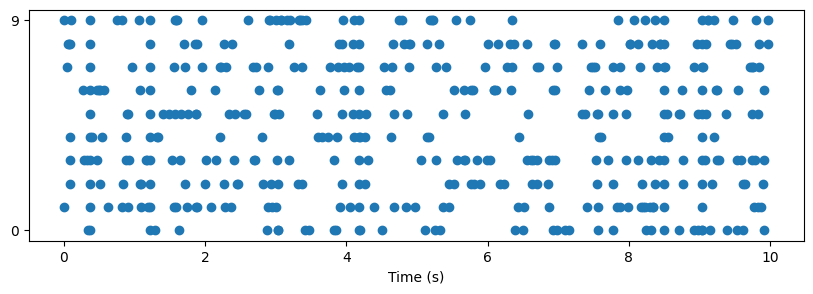

In [5]:
from viziphant.rasterplot import rasterplot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,3))
rasterplot(spiketrains, axes=ax)

In [6]:
A

[0, 0.98, 0, 0, 0, 0, 0, 0, 0, 0, 0.02]

In [ ]:
# rasterplot?

In [7]:
for i in range(90):
    spiketrains.append(elephant.spike_train_generation.homogeneous_poisson_process(
        rate=5*pq.Hz, t_stop=10*pq.s))

In [8]:
st = spiketrains[0]
st.times

array([0.3428428 , 0.36964823, 1.22303783, 1.28863725, 1.63905792,
       2.88270894, 3.03516076, 3.03817857, 3.41886987, 3.46763254,
       3.83237276, 3.85699453, 4.17892833, 4.18912792, 4.50264362,
       5.11709083, 5.25194019, 5.32478839, 6.39516735, 6.50198542,
       6.92936517, 6.98985003, 7.10209661, 7.15895706, 7.56589684,
       7.78118491, 8.24170386, 8.31116287, 8.49874386, 8.70570514,
       8.91675734, 8.97507227, 9.03423901, 9.03853449, 9.15468654,
       9.39298729, 9.52941963, 9.61571811, 9.9134528 ]) * s

In [9]:
patterns = elephant.spade.spade(
    spiketrains=spiketrains, binsize=1*pq.ms, winlen=1, min_spikes=3,
    n_surr=100, dither=5*pq.ms,
    psr_param=[0,0,0],
    output_format='patterns')['patterns']

Time for data mining: 0.22276735305786133
Time for pvalue spectrum computation: 28.62463879585266


In [10]:
patterns

[{'itemset': (3, 4, 7, 9, 0, 2, 5, 6, 8, 1),
  'windows_ids': (369, 1223, 4178, 8498, 9038),
  'neurons': [3, 4, 7, 9, 0, 2, 5, 6, 8, 1],
  'lags': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]) * ms,
  'times': array([ 369., 1223., 4178., 8498., 9038.]) * ms,
  'signature': (10, 5),
  'pvalue': 0.0}]

<AxesSubplot: xlabel='Time (s)', ylabel='Neuron'>

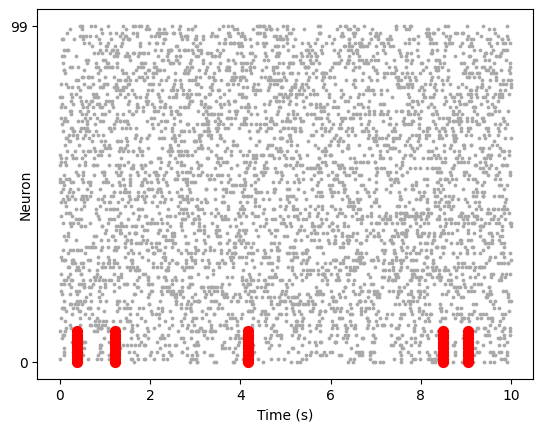

In [11]:
viziphant.patterns.plot_patterns(spiketrains, patterns)

## scanning some parameters

the above as one function:

In [12]:
A_sync = 0.02
shift = 1.0

def generate_and_test(A_sync=A_sync, shift=shift):
    A = [0]+[1.-A_sync]+[0]*8+[A_sync]
    spiketrains = elephant.spike_train_generation.compound_poisson_process(
                             rate=5*pq.Hz, A=A, shift=shift*pq.ms, t_stop=10*pq.s)
    for i in range(90):
        spiketrains.append(elephant.spike_train_generation.homogeneous_poisson_process(
            rate=5*pq.Hz, t_stop=10*pq.s))
    patterns = elephant.spade.spade(
                                spiketrains=spiketrains, binsize=1*pq.ms, winlen=1, min_spikes=3,
                                n_surr=100,dither=5*pq.ms,
                                psr_param=[0,0,0],
                                output_format='patterns')['patterns']
    return patterns


* changing the synchrony probability to check when SPADE will begin to fail:


In [13]:
for A_sync_ in np.logspace(-2, -.5, 10):
    patterns = generate_and_test(A_sync=A_sync_)
    print(patterns)

Time for data mining: 0.23911809921264648
Time for pvalue spectrum computation: 27.559032201766968
[{'itemset': (2, 6, 5, 3), 'windows_ids': (526, 2848, 7539), 'neurons': [2, 6, 5, 3], 'lags': array([0., 0., 0.]) * ms, 'times': array([ 526., 2848., 7539.]) * ms, 'signature': (4, 3), 'pvalue': 0.0}, {'itemset': (1, 8, 0, 4, 9), 'windows_ids': (527, 5348, 7540), 'neurons': [1, 8, 0, 4, 9], 'lags': array([0., 0., 0., 0.]) * ms, 'times': array([ 527., 5348., 7540.]) * ms, 'signature': (5, 3), 'pvalue': 0.0}]
Time for data mining: 0.2018578052520752
Time for pvalue spectrum computation: 28.384434461593628
[{'itemset': (2, 3, 4), 'windows_ids': (2624, 7897, 7972, 9440), 'neurons': [2, 3, 4], 'lags': array([0., 0.]) * ms, 'times': array([2624., 7897., 7972., 9440.]) * ms, 'signature': (3, 4), 'pvalue': 0.0}, {'itemset': (2, 3, 0), 'windows_ids': (1361, 7897), 'neurons': [2, 3, 0], 'lags': array([0., 0.]) * ms, 'times': array([1361., 7897.]) * ms, 'signature': (3, 2), 'pvalue': 0.46}, {'itemse


* adding a random shift to check robustness of SPADE:


In [14]:
for shift_ in np.logspace(-1, 1, 10, base=10, endpoint=True):
    patterns = generate_and_test(shift=shift_)
    print(patterns)

Time for data mining: 0.20065832138061523
Time for pvalue spectrum computation: 27.570959329605103
[{'itemset': (2, 4, 6, 8, 7, 1, 9, 0, 5, 3), 'windows_ids': (1103, 1301, 1496, 1603, 1655, 1850, 2344, 2739, 3722, 4236, 8731), 'neurons': [2, 4, 6, 8, 7, 1, 9, 0, 5, 3], 'lags': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]) * ms, 'times': array([1103., 1301., 1496., 1603., 1655., 1850., 2344., 2739., 3722.,
       4236., 8731.]) * ms, 'signature': (10, 11), 'pvalue': 0.0}]
Time for data mining: 0.26452159881591797
Time for pvalue spectrum computation: 29.464800596237183
[{'itemset': (4, 8, 7, 5, 2, 9, 6, 3, 1, 0), 'windows_ids': (463, 622, 2280, 5300, 5723, 7048, 7907, 8199, 8909, 9869), 'neurons': [4, 8, 7, 5, 2, 9, 6, 3, 1, 0], 'lags': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]) * ms, 'times': array([ 463.,  622., 2280., 5300., 5723., 7048., 7907., 8199., 8909.,
       9869.]) * ms, 'signature': (10, 10), 'pvalue': 0.0}]
Time for data mining: 0.19669795036315918
Time for pvalue spectrum 